# Objects Room

Sample keys:
```
image       uint8   [64, 64, 3]
mask        bool    [M, 64, 64]
```

Where `M` is:
- `7`  for `train`
- `10` for `six_objects`
- `4`  for `empty_room`
- `10` for `identical_color`

Also, the first 4 masks are:
- `0` the sky
- `1` the room walls
- `2` one wall
- `3` the other wall

https://github.com/deepmind/multi_object_datasets

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import multi_object_datasets.objects_room
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

tf.get_logger().setLevel("WARNING")

num_cpus = 16
batch_size = 1000
data_root = Path.home() / "multi-object-datasets" / "objects_room"
mode_to_file = {
    "six_objects": "objects_room_test_six_objects.tfrecords",
    "empty_room": "objects_room_test_empty_room.tfrecords",
    "identical_color": "objects_room_test_identical_color.tfrecords",
    "train": "objects_room_train.tfrecords",
}

six_objects


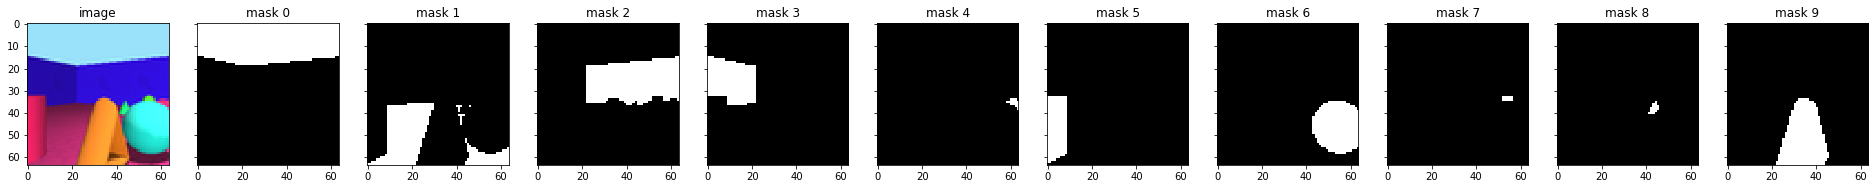

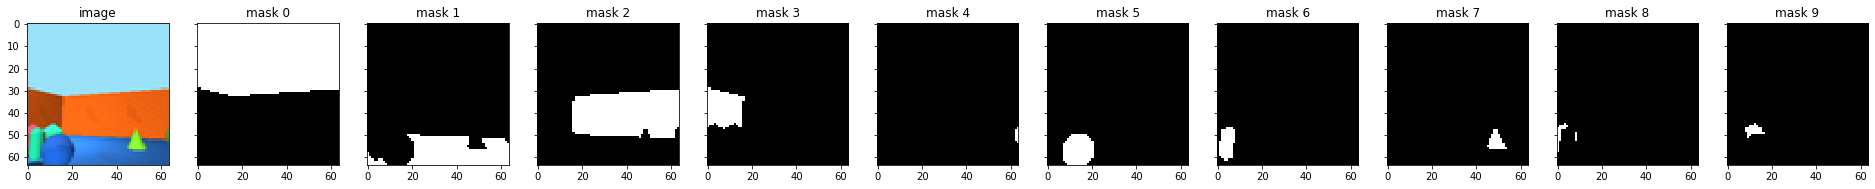

empty_room


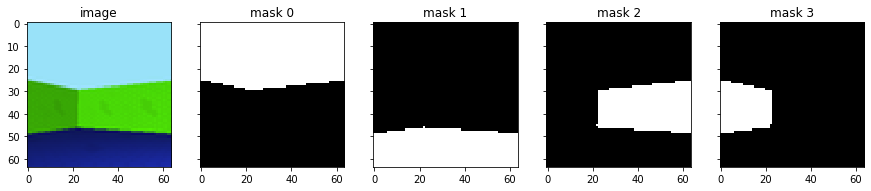

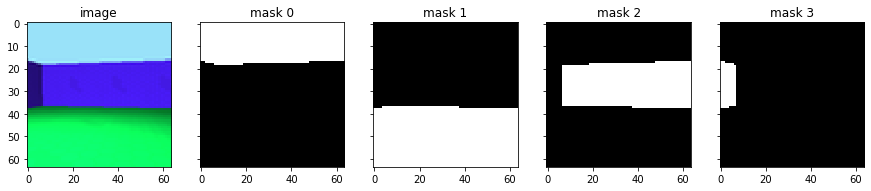

identical_color


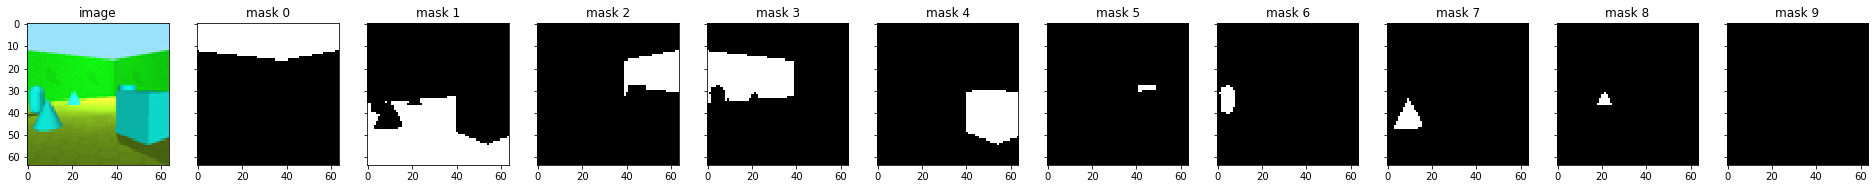

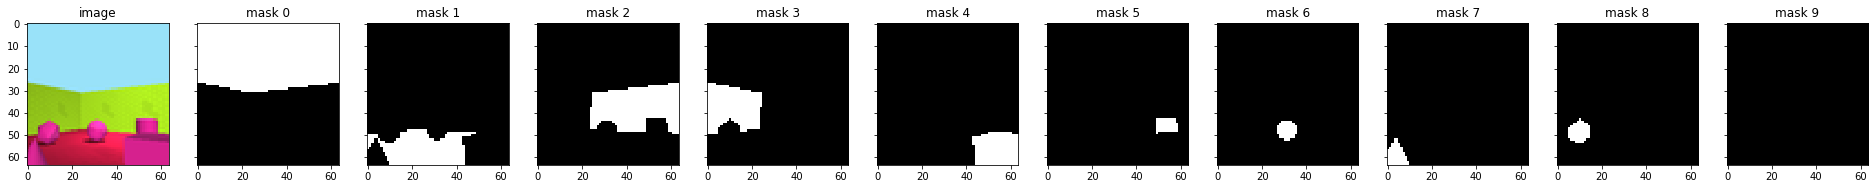

train


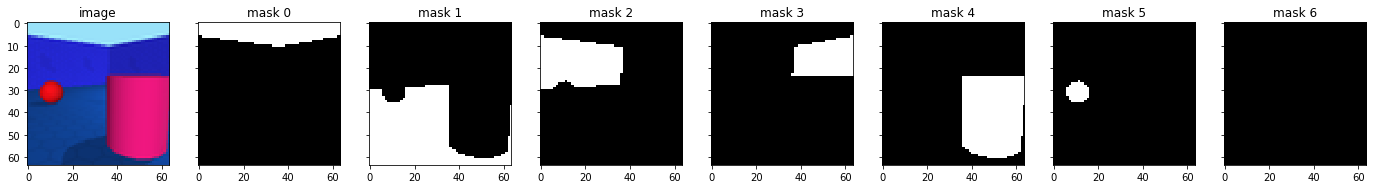

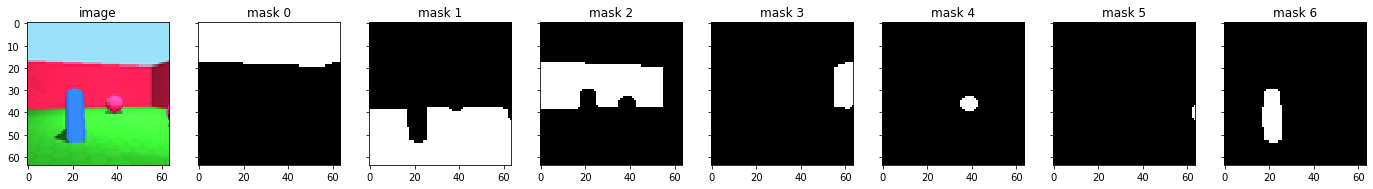

In [2]:
def show_sample(sample):
    fig, axs = plt.subplots(
        1,
        1 + sample["mask"].shape[0],
        figsize=3 * np.array([1 + sample["mask"].shape[0], 1]),
        sharex=True,
        sharey=True,
    )

    axs[0].imshow(sample["image"], interpolation="none")
    axs[0].set_title("image")

    for m in range(sample["mask"].shape[0]):
        axs[m + 1].imshow(sample["mask"][m], cmap="gray", interpolation="none")
        axs[m + 1].set_title(f"mask {m}")

    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)


def fix_tf_dtypes(sample):
    sample["mask"] = tf.cast(tf.squeeze(sample["mask"], -1), tf.bool)
    return sample


for mode, filename in mode_to_file.items():
    print(mode)
    tfr_path = data_root / filename

    ds = multi_object_datasets.objects_room.dataset(tfr_path.as_posix(), mode)
    ds = ds.map(fix_tf_dtypes)
    ds = ds.take(2)
    ds = ds.as_numpy_iterator()

    for sample in ds:
        show_sample(sample)

In [3]:
for mode, filename in mode_to_file.items():
    tfr_path = data_root / filename
    h5_path = tfr_path.with_suffix(".h5")

    ds = multi_object_datasets.objects_room.dataset(
        tfr_path.as_posix(), mode, map_parallel_calls=num_cpus
    )
    ds = ds.batch(batch_size)
    ds = ds.as_numpy_iterator()

    with h5py.File(h5_path, "w") as h5_file:
        for batch in tqdm.tqdm(ds, desc=mode, unit=" samples", unit_scale=batch_size):
            for k in batch.keys():
                if k not in h5_file:
                    h5_file.create_dataset(
                        k,
                        data=batch[k],
                        shape=batch[k].shape,
                        maxshape=(None, *batch[k].shape[1:]),
                        chunks=True,
                        compression="lzf",
                        # compression="gzip",
                        # compression_opts=9,
                    )
                else:
                    h5_file[k].resize(h5_file[k].shape[0] + batch[k].shape[0], axis=0)
                    h5_file[k][-batch[k].shape[0] :] = batch[k]

    with h5py.File(h5_path, "r") as h5_file:
        for k in h5_file.keys():
            print(f"{k:<15} {str(h5_file[k].dtype):<10} {h5_file[k].shape}")

six_objects: 1000 samples [00:01, 708.17 samples/s]


image           uint8      (992, 64, 64, 3)
mask            uint8      (992, 10, 64, 64, 1)


empty_room: 1000 samples [00:01, 969.55 samples/s]


image           uint8      (992, 64, 64, 3)
mask            uint8      (992, 4, 64, 64, 1)


identical_color: 1000 samples [00:01, 719.59 samples/s]


image           uint8      (992, 64, 64, 3)
mask            uint8      (992, 10, 64, 64, 1)


train: 1000000 samples [12:50, 1298.38 samples/s]


image           uint8      (1000000, 64, 64, 3)
mask            uint8      (1000000, 7, 64, 64, 1)
